# 3.1: 自动微分量子门和线路

由自动微分量子门构成的量子线路，被称变分量子线路 （variational quantum circuit，简称VQC，或称自动微分量子线路（ADQC）、参数化量子线路（PQC））

更一般的概念：变分量子算法（VQA）

## 量子态制备

以量子态制备（quantum state preparation）任务为例：将给定初态利用量子线路演化至目标量子态

量子态制备需极大化目标态与末态间的保真度（fidelity）：

$f = |\langle\varphi'|\varphi^{\text{target}}\rangle|$

* 由量子态归一性可得，保真度满足：$0 \leq f \leq 1$
* $f = 1$时，两个量子态间仅相差一个相位因子，可认为二者表示同一个态
* $f = 0$时，两个量子态正交

这里的变分量子门将主要采用任意单体么正门的旋转表示（参考2.2节）:

$\hat{U} = e^{i\eta}\hat{R}^{(z)}(\beta)\hat{R}^{(y)}(\gamma)\hat{R}^{(z)}(\delta) = \begin{pmatrix} e^{i(\eta-\beta/2-\delta/2)}\cos\frac{\gamma}{2} & -e^{i(\eta-\beta/2+\delta/2)}\sin\frac{\gamma}{2} \\ e^{i(\eta+\beta/2-\delta/2)}\sin\frac{\gamma}{2} & e^{i(\eta+\beta/2+\delta/2)}\cos\frac{\gamma}{2} \end{pmatrix}$

> 这里的变分参数有 $\eta, \beta, \gamma, \delta$四个，分别对应于旋转门的相位、$R^{(z)}$门的角度、$R^{(y)}$门的角度和$R^{(z)}$门的角度

> 取决于优化方法和损失函数，$e^{i\eta}$ 可以省略

## Code

In [1]:
import torch

In [ ]:
# |export tensor_gates.functional
from typing import Literal
from tensor_network.utils import map_float_to_complex


def pauli_operator(
    *,
    pauli: Literal["X", "Y", "Z", "ID"],
    double_precision: bool = False,
    force_complex: bool = False,
) -> torch.Tensor:
    """
    Returns the Pauli operator as a tensor.
    Args:
        pauli (str): The Pauli operator to return. Must be one of 'X', 'Y', 'Z', or 'ID'.
        double_precision (bool): If True, use double precision for the tensor.
        force_complex (bool): If True, force the tensor to be complex.
    Returns:
        torch.Tensor: The Pauli operator as a tensor.
    """
    assert pauli in ["X", "Y", "Z", "ID"], f"Invalid Pauli operator: {pauli}"
    if double_precision:
        dtype_complex = torch.complex128
        if force_complex:
            dtype_default = dtype_complex
        else:
            dtype_default = torch.float64
    else:
        dtype_complex = torch.complex64
        if force_complex:
            dtype_default = dtype_complex
        else:
            dtype_default = torch.float32

    if pauli == "X":
        return torch.tensor([[0, 1], [1, 0]], dtype=dtype_default)
    elif pauli == "Y":
        return torch.tensor([[0, -1j], [1j, 0]], dtype=dtype_complex)
    elif pauli == "Z":
        return torch.tensor([[1, 0], [0, -1]], dtype=dtype_default)
    elif pauli == "ID":
        return torch.eye(2, dtype=dtype_default)
    else:
        raise Exception("Unreachable code")


def _float_convert_to_tensor(
    value: float | torch.Tensor, device: torch.device, dtype: torch.dtype
) -> torch.Tensor:
    if isinstance(value, torch.Tensor):
        return value
    elif isinstance(value, float):
        return torch.tensor(value, dtype=dtype, device=device)
    else:
        raise TypeError(f"Expected float or torch.Tensor, got {type(value)}")


def rotate(
    *,
    params_vec: torch.Tensor | None = None,
    ita: torch.Tensor | float | None = None,
    beta: torch.Tensor | float | None = None,
    delta: torch.Tensor | float | None = None,
    gamma: torch.Tensor | float | None = None,
    dtype: torch.dtype | None = None,
    device: torch.device | None = None,
) -> torch.Tensor:
    """
    Returns the rotation gate as a tensor.
    Args:
        params_vec (torch.Tensor): A 4-element vector containing the parameters [ita, beta, delta, gamma].
        ita (torch.Tensor | float | None): The first parameter of the rotation gate.
        beta (torch.Tensor | float | None): The second parameter of the rotation gate.
        delta (torch.Tensor | float | None): The third parameter of the rotation gate.
        gamma (torch.Tensor | float | None): The fourth parameter of the rotation gate.
        dtype (torch.dtype | None): The data type of the tensor.
        device (torch.device | None): The device to create the tensor on.
    Returns:
        torch.Tensor: The rotation gate as a tensor.
    """

    assert params_vec is not None or (
        ita is not None and beta is not None and delta is not None and gamma is not None
    ), "Either params_vec or ita, beta, delta, and gamma must be provided"
    if params_vec is not None:
        assert isinstance(params_vec, torch.Tensor), "params must be a torch.Tensor"
        assert params_vec.shape == (4,), "params must be a 4-element vector"
        dtype = params_vec.dtype if dtype is None else dtype
        device = params_vec.device if device is None else device
        assert dtype in [torch.float32, torch.float64], "params must be float32 or float64"
        beta, delta, ita, gamma = params_vec[0], params_vec[1], params_vec[2], params_vec[3]
    else:
        ita = _float_convert_to_tensor(ita, device=device, dtype=dtype)
        beta = _float_convert_to_tensor(beta, device=device, dtype=dtype)
        delta = _float_convert_to_tensor(delta, device=device, dtype=dtype)
        gamma = _float_convert_to_tensor(gamma, device=device, dtype=dtype)
        assert ita.shape == beta.shape == delta.shape == gamma.shape == (), (
            "ita, beta, delta, and gamma must be scalars"
        )
        assert ita.dtype == beta.dtype == delta.dtype == gamma.dtype, (
            "ita, beta, delta, and gamma must have the same dtype"
        )
        assert ita.device == beta.device == delta.device == gamma.device, (
            "ita, beta, delta, and gamma must have the same device"
        )
        dtype = ita.dtype if dtype is None else dtype
        device = ita.device if device is None else device
        assert dtype in [torch.float32, torch.float64], (
            "ita, beta, delta, and gamma must be float32 or float64"
        )

    gate_dtype = map_float_to_complex(dtype=dtype)
    # calculate the matrix for the beta terms
    beta_coefficient_matrix = torch.tensor(
        [[-0.5, -0.5], [0.5, 0.5]], device=device, dtype=gate_dtype
    )
    beta_matrix = beta_coefficient_matrix * beta
    # calculate the matrix for the delta terms
    delta_coefficient_matrix = beta_coefficient_matrix.T
    delta_matrix = delta_coefficient_matrix * delta
    # calculate the matrix for the gamma terms
    gamma_2 = gamma / 2
    gamma_coefficient_matrix_cosine = torch.eye(2, device=device, dtype=gate_dtype)
    gamma_coefficient_matrix_sine = torch.tensor([[0, 1], [1, 0]], device=device, dtype=gate_dtype)
    gamma_matrix = gamma_coefficient_matrix_cosine * torch.cos(
        gamma_2
    ) + gamma_coefficient_matrix_sine * torch.sin(gamma_2)
    # set the coefficient matrix in front of e
    coefficient_matrix = torch.tensor([[1, -1], [1, 1]], device=device, dtype=gate_dtype)
    gate = coefficient_matrix * torch.exp(1j * (ita + beta_matrix + delta_matrix)) * gamma_matrix
    return gate

In [3]:
# testing against reference code

from tensor_network import setup_ref_code_import
from Library.MathFun import rotate as rotate_ref

for _ in range(10):
    params = torch.rand(4, dtype=torch.float64)
    gate_ref = rotate_ref(params)
    gate = rotate(params_vec=params)
    assert torch.allclose(gate_ref, gate), f"Gates do not match, {gate_ref} != {gate}"

From setup_ref_code_import:
  Added reference_code_path='/Users/zhiqiu/offline_code/personal/tensor_network/reference_code' to sys.path.
  You can import the reference code now.


### VQC Example

![VQC Example](./images/vqc_example.png)

In [4]:
from matplotlib import pyplot as plt
from torch.optim import Adam
from tqdm.auto import tqdm
from tensor_network.tensor_gates.functional import apply_gate

In [ ]:
# |export tensor_utils
def zeros_state(*, num_qubits: int, dtype: torch.dtype) -> torch.Tensor:
    """
    Returns the zero state as a tensor.
    Args:
        num_qubits (int): The number of qubits.
        dtype (torch.dtype): The data type of the tensor.
    Returns:
        torch.Tensor: The zero state as a tensor.
    """
    assert num_qubits > 0, "num_qubits must be positive"
    assert dtype in [torch.complex64, torch.complex128], "dtype must be complex64 or complex128"
    state = torch.zeros((2**num_qubits,), dtype=dtype)
    state[0] = 1.0
    shape = [2] * num_qubits
    state = state.reshape(shape)
    return state

  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.8764612674713135
Iteration 100, Loss: 0.7192366123199463
Iteration 200, Loss: 0.5681653022766113
Iteration 300, Loss: 0.4575917720794678
Iteration 400, Loss: 0.37555068731307983
Iteration 500, Loss: 0.31506890058517456
Iteration 600, Loss: 0.27236407995224
Iteration 700, Loss: 0.24259042739868164
Iteration 800, Loss: 0.22074061632156372
Iteration 900, Loss: 0.20286035537719727
Iteration 1000, Loss: 0.1865643858909607
Iteration 1100, Loss: 0.1709270477294922
Iteration 1200, Loss: 0.15602248907089233
Iteration 1300, Loss: 0.1423959732055664
Iteration 1400, Loss: 0.1306290626525879
Iteration 1500, Loss: 0.1210622787475586
Iteration 1600, Loss: 0.1136903166770935
Iteration 1700, Loss: 0.10820651054382324
Iteration 1800, Loss: 0.1041291356086731
Iteration 1900, Loss: 0.10092979669570923
Iteration 2000, Loss: 0.09811097383499146
Iteration 2100, Loss: 0.09521538019180298
Iteration 2200, Loss: 0.09177309274673462
Iteration 2300, Loss: 0.0872073769569397
Iteration 2400, Los

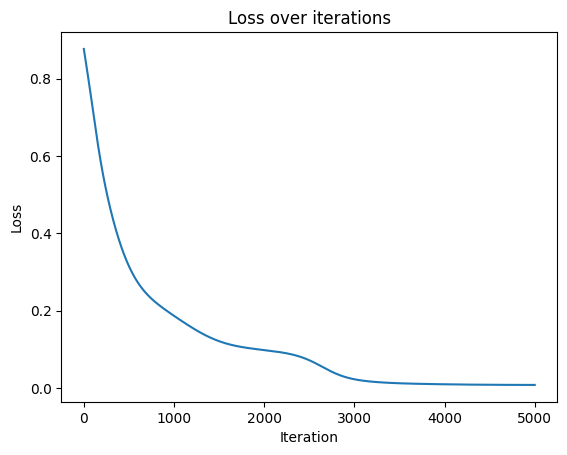

In [6]:
lr = 1e-3
iterations = 5000
# set target states
num_qubits = 3
target_state = torch.randn(*([2] * num_qubits), dtype=torch.complex64)
target_state = target_state / torch.norm(target_state)
# for each qubit, we have 2 gates, which are 4 parameters each
num_gates_per_qubit = 2
param_num_per_gate = 4
params = torch.randn(
    num_qubits, num_gates_per_qubit, param_num_per_gate, dtype=torch.float32, requires_grad=True
)
optimizer = Adam([params], lr=lr)

not_gate = pauli_operator(pauli="X", double_precision=False, force_complex=True)
losses = torch.empty(iterations, dtype=torch.float32)

for i in tqdm(range(iterations)):
    gates = [[] for _ in range(num_qubits)]
    for q_idx in range(num_qubits):
        for g_idx in range(num_gates_per_qubit):
            gates[q_idx].append(rotate(params_vec=params[q_idx, g_idx]))

    state = zeros_state(num_qubits=num_qubits, dtype=torch.complex64)
    for q_idx in range(num_qubits):
        rotate_gates = gates[q_idx]
        state = apply_gate(quantum_state=state, gate=rotate_gates[0], target_qubit=q_idx)
        state = apply_gate(
            quantum_state=state,
            gate=not_gate,
            control_qubit=q_idx,
            target_qubit=(q_idx + 1) % num_qubits,
        )
        state = apply_gate(quantum_state=state, gate=rotate_gates[1], target_qubit=q_idx)
    # loss = 1 - fidelity
    loss = 1 - (state.conj() * target_state).sum().norm()
    losses[i] = loss.detach()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {losses[i].item()}")

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()